In [ ]:
# pip install ultralytics supervision pandas scikit-learn scikit-image matplotlib seaborn pymupdf pytesseract

## Data Preprocesing

In [18]:
import pandas
import fitz
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil
from pathlib import Path
import pytesseract


pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

### Converting provided PDFs to images

In [6]:
from data_utils import pdf_to_images

pdf_to_images('data/1_raw/books/book1.pdf', 'data/2_splitted/book1')
pdf_to_images('data/1_raw/books/book2.pdf', 'data/2_splitted/book2')
pdf_to_images('data/1_raw/books/book3.pdf', 'data/2_splitted/book3')
pdf_to_images('data/1_raw/books/book4.pdf', 'data/2_splitted/book4')
pdf_to_images('data/1_raw/books/book5.pdf', 'data/2_splitted/book5')
pdf_to_images('data/1_raw/books/book6.pdf', 'data/2_splitted/book6')
pdf_to_images('data/1_raw/books/book7.pdf', 'data/2_splitted/book7')
pdf_to_images('data/1_raw/books/book8.pdf', 'data/2_splitted/book8')

Processing complete! Saved 31 images in 'data/2_splitted/book1'.
Processing complete! Saved 31 images in 'data/2_splitted/book2'.
Processing complete! Saved 16 images in 'data/2_splitted/book3'.
Processing complete! Saved 6 images in 'data/2_splitted/book4'.
Processing complete! Saved 11 images in 'data/2_splitted/book5'.
Processing complete! Saved 9 images in 'data/2_splitted/book6'.
Processing complete! Saved 9 images in 'data/2_splitted/book7'.
Processing complete! Saved 11 images in 'data/2_splitted/book8'.


### preprocessing images

In [11]:
from data_utils import (load_image, correct_skew, normalize_image, ensure_300ppi)

def transform_images( image_path, output_path=None):
    results = {}

    image = load_image(image_path)
    results['original'] = image.copy()

    deskewed = correct_skew(image)
    results['deskewed'] = deskewed.copy()
    
    normalized = normalize_image(deskewed)
    results['normalized'] = normalized.copy()
    
    scaled = ensure_300ppi(normalized)
    results['scaled'] = scaled.copy()

    return results


def process_books(input_dir, output_dir, transform_images):
    """Process all book images and save transformed versions."""

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through each book directory
    for book in os.listdir(input_dir):
        book_path = os.path.join(input_dir, book)

        # Skip if not a directory
        if not os.path.isdir(book_path):
            continue

        print(f"Processing book: {book}")

        # Process each image in the book
        for image_name in os.listdir(book_path):
            # Skip non-image files
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            # Extract page number from filename
            page_number = image_name.split('.')[0]
            image_path = os.path.join(book_path, image_name)

            # Define output path
            output_image_path = os.path.join(output_dir, f"{book}_{page_number}.png")

            try:
                # Apply transformation
                transformed_result = transform_images(image_path)
                final_image = transformed_result['normalized']

                # Save transformed image (convert RGB to BGR for OpenCV)
                cv2.imwrite(output_image_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

            except Exception as e:
                print(f"  Error processing {image_name}: {str(e)}")
                

# Run the processing function
input_dir = "data/2_splitted"
output_dir = "data/3_transformed"

process_books(input_dir, output_dir, transform_images)

Processing book: book1
Processing book: book2
Processing book: book3
Processing book: book4
Processing book: book5
Processing book: book6
Processing book: book7
Processing book: book8


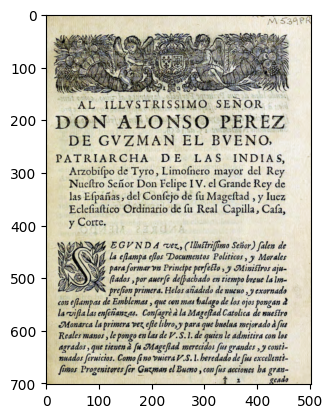

In [12]:
img = load_image('data/3_transformed/book6_1.png')
plt.imshow(img)

### Resizing and padding to a fixed size

In [ ]:
from PIL import Image
import os
from data_utils import resize_and_pad

target_height, target_width = 512,384 
for image in os.listdir("data/3_transformed"):
    img = Image.open(f"data/3_transformed/{image}")
    processed_img = resize_and_pad(img, target_height, target_width, output_dir="data/4_final")

## Mask Generation

In [19]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
import os
from tqdm import tqdm

def generate_mask(image_path):

    # Load the image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    # Create a blank mask with the same dimensions as the image
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Convert to grayscale if not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
        
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # Get detailed OCR data
    data = pytesseract.image_to_data(thresh, config='--psm 6', output_type=pytesseract.Output.DICT)
    
    # Group words into sentences based on their positions
    n_boxes = len(data['text'])
    if n_boxes == 0:
        return mask
    
    # Create a list to track sentence groups
    sentences = []
    current_sentence = []
    current_line = data['line_num'][0]
    
    for i in range(n_boxes):
        # Skip empty text
        if not data['text'][i].strip():
            continue
            
        # If confidence is too low, skip
        if int(data['conf'][i]) < 30:
            continue
            
        # If this is a new line, start a new sentence
        if data['line_num'][i] != current_line:
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
            current_line = data['line_num'][i]
        
        # Add word to current sentence
        current_sentence.append({
            'x': data['left'][i],
            'y': data['top'][i],
            'w': data['width'][i],
            'h': data['height'][i],
            'text': data['text'][i]
        })
    
    # Add the last sentence if it exists
    if current_sentence:
        sentences.append(current_sentence)
    
    # Draw the sentence boxes on the mask
    for sentence in sentences:
        if not sentence:
            continue
            
        # Find the bounding rectangle of the entire sentence
        min_x = min(word['x'] for word in sentence)
        min_y = min(word['y'] for word in sentence)
        max_x = max(word['x'] + word['w'] for word in sentence)
        max_y = max(word['y'] + word['h'] for word in sentence)
        
        # Add padding to the sentence box (optional)
        padding = 5
        min_x = max(0, min_x - padding)
        min_y = max(0, min_y - padding) 
        max_x = min(width, max_x + padding)
        max_y = min(height, max_y + padding)
        
        # Draw the sentence box on the mask
        cv2.rectangle(mask, (min_x, min_y), (max_x, max_y), 255, -1)
    
    # Optional: Resize mask to standard dimensions if needed
    if height != 512 or width != 384:
        mask = cv2.resize(mask, (384, 512), interpolation=cv2.INTER_NEAREST)
    
    return mask

def process_dataset(image_folder, output_folder):

    os.makedirs(output_folder, exist_ok=True)

    image_files = [f for f in os.listdir(image_folder)]

    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(image_folder, img_file)

        try:
            mask = generate_mask(img_path)

            # Save mask
            mask_filename = os.path.splitext(img_file)[0] + '_mask.png'
            mask_path = os.path.join(output_folder, mask_filename)
            cv2.imwrite(mask_path, mask)

        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")



In [20]:
process_dataset("data/4_final", "data/masks")

Processing images: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]


# Model Building

## Importing dependencies

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import segmentation_models_pytorch as smp

# Check if GPU is available

OUTPUT_DIR = "model_output/model1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Defining dataset class

In [2]:
# Dataset class
class LayoutDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Convert to binary mask (0 or 1)
        mask = mask / 255.0
        
        # Apply transforms
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to tensor
        image = transforms.ToTensor()(image)
        image = self.normalize(image)
        mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        return image, mask

In [3]:
# Data preparation
def prepare_data(image_dir, mask_dir, test_size=0.2, val_size=0.1):
    # Get all image filenames
    image_files = [f for f in os.listdir(image_dir)]
    
    # Create pairs of image and mask paths
    image_paths = []
    mask_paths = []
    
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mask_file = os.path.splitext(img_file)[0] + '_mask.png'  # Assuming this naming convention
        mask_path = os.path.join(mask_dir, mask_file)
        
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
    
    # Split into train, validation, and test sets
    train_img_paths, test_img_paths, train_mask_paths, test_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=test_size, random_state=42
    )
    
    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
        train_img_paths, train_mask_paths, test_size=val_size/(1-test_size), random_state=42
    )
    
    print(f"Train set: {len(train_img_paths)} images")
    print(f"Validation set: {len(val_img_paths)} images")
    print(f"Test set: {len(test_img_paths)} images")
    
    return (train_img_paths, train_mask_paths), (val_img_paths, val_mask_paths), (test_img_paths, test_mask_paths)

## Defining U-Net model

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True, negative_slope=0.2),  # LeakyReLU for better gradient flow
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True, negative_slope=0.2)
        )

    def forward(self, x):
        return self.double_conv(x)

# Attention Gate for focusing on relevant features
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, use_residual=True):
        super().__init__()
        self.use_residual = use_residual
        
        self.maxpool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels)
        
        # Residual connection
        if use_residual:
            self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        pooled = self.maxpool(x)
        conv_output = self.conv(pooled)
        
        if self.use_residual:
            residual = self.residual(pooled)
            residual = self.bn(residual)
            return conv_output + residual
        else:
            return conv_output

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True, use_attention=True):
        super().__init__()
        
        self.use_attention = use_attention
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            
        # Attention gate
        if use_attention:
            self.attn = AttentionGate(in_channels//2, in_channels//2, in_channels//4)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Handle size differences for feature map concatenation
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Apply attention
        if self.use_attention:
            x2 = self.attn(x1, x2)
            
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False, dropout_rate=0.2, use_deep_supervision=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.dropout_rate = dropout_rate
        self.use_deep_supervision = use_deep_supervision
        
        # Initial feature extraction
        self.inc = DoubleConv(n_channels, 64)
        
        # Downsampling path
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        # Spatial and channel attention at bottleneck for focusing on important features
        self.dropout = nn.Dropout2d(dropout_rate)
        
        # Upsampling path with attention gates
        self.up1 = Up(1024, 512 // factor, bilinear, use_attention=True)
        self.up2 = Up(512, 256 // factor, bilinear, use_attention=True)
        self.up3 = Up(256, 128 // factor, bilinear, use_attention=True)
        self.up4 = Up(128, 64, bilinear, use_attention=True)
        
        # Main output
        self.outc = OutConv(64, n_classes)
        
        # Deep supervision branches for better gradient flow
        if use_deep_supervision:
            self.ds1 = OutConv(512 // factor, n_classes)
            self.ds2 = OutConv(256 // factor, n_classes)
            self.ds3 = OutConv(128 // factor, n_classes)
        
        self.initialize_weights()
    
    def initialize_weights(self):
        # Kaiming initialization (better for ReLU/LeakyReLU)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoding
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Bottleneck
        x5 = self.dropout(x5)
        
        # Decoding
        x = self.up1(x5, x4)
        if self.use_deep_supervision:
            ds1 = self.ds1(x)
            
        x = self.up2(x, x3)
        if self.use_deep_supervision:
            ds2 = self.ds2(x)
            
        x = self.up3(x, x2)
        if self.use_deep_supervision:
            ds3 = self.ds3(x)
            
        x = self.up4(x, x1)
        output = self.outc(x)
        
        # Apply sigmoid for binary segmentation
        if self.n_classes == 1:
            output = torch.sigmoid(output)
            
            if self.use_deep_supervision:
                ds1 = torch.sigmoid(ds1)
                ds2 = torch.sigmoid(ds2)
                ds3 = torch.sigmoid(ds3)
                
                # Return main output and deep supervision outputs
                return output, ds1, ds2, ds3
            
            return output
        
        # For multi-class, use softmax instead of sigmoid
        else:
            if self.use_deep_supervision:
                return output, ds1, ds2, ds3
            return output

## Defining training loop

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, 
                patience=7, min_delta=0.001, output_dir=OUTPUT_DIR):

    os.makedirs(output_dir, exist_ok=True)
    
    best_val_loss = float('inf')
    best_val_iou = 0.0  # Track best IoU as well
    best_model_state = None
    counter = 0  # Counter for early stopping
    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'train_iou': [],
        'val_iou': [],
        'train_dice': [],
        'val_dice': [],
        'learning_rate': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 40)
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_iou_sum = 0.0
        train_dice_sum = 0.0
        batch_count = 0
        
        for inputs, masks in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            # Convert float masks to long for SMP metrics
            masks_int = (masks > 0.5).long()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass - handle both standard and deep supervision outputs
            outputs = model(inputs)
            
            # Check if model returns deep supervision outputs
            if model.use_deep_supervision and isinstance(outputs, tuple):
                main_output = outputs[0]  # Main output is the first element
                loss = criterion(outputs, masks)  # The criterion should handle deep supervision
            else:
                main_output = outputs
                loss = criterion(main_output, masks)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            batch_size = inputs.size(0)
            batch_count += 1
            train_loss += loss.item() * batch_size
            
            # Calculate IOU and Dice scores using SMP metrics with integer masks
            # Use only the main output for metrics
            tp, fp, fn, tn = smp.metrics.get_stats(
                main_output,
                masks_int,
                mode='binary',
                threshold=0.5  # Consistent threshold
            )
            
            batch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            batch_dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
            
            train_iou_sum += batch_iou * batch_size
            train_dice_sum += batch_dice * batch_size
        
        train_loss /= len(train_loader.dataset)
        train_iou = train_iou_sum / len(train_loader.dataset)
        train_dice = train_dice_sum / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou_sum = 0.0
        val_dice_sum = 0.0
        
        with torch.no_grad():
            for inputs, masks in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                masks = masks.to(device)
                
                # Convert float masks to long for SMP metrics
                masks_int = (masks > 0.5).long()
                
                # Forward pass - handle both standard and deep supervision outputs
                outputs = model(inputs)
                
                # Check if model returns deep supervision outputs
                if model.use_deep_supervision and isinstance(outputs, tuple):
                    main_output = outputs[0]  # Main output is the first element
                    loss = criterion(outputs, masks)  # The criterion should handle deep supervision
                else:
                    main_output = outputs
                    loss = criterion(main_output, masks)
                
                # Statistics
                batch_size = inputs.size(0)
                val_loss += loss.item() * batch_size
                
                # Calculate IOU and Dice scores - use only main output
                tp, fp, fn, tn = smp.metrics.get_stats(
                    main_output,
                    masks_int,
                    mode='binary',
                    threshold=0.5
                )
                
                batch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
                batch_dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
                
                val_iou_sum += batch_iou * batch_size
                val_dice_sum += batch_dice * batch_size
        
        val_loss /= len(val_loader.dataset)
        val_iou = val_iou_sum / len(val_loader.dataset)
        val_dice = val_dice_sum / len(val_loader.dataset)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update learning rate
        if scheduler is not None:
            scheduler.step(val_loss)
        
        # Update history
        history['epoch'].append(epoch+1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        history['learning_rate'].append(current_lr)
        
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print(f'Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}')
        print(f'Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}')
        print('-' * 40)

        # First check loss improvement
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            counter = 0
            print(f"Validation loss improved to {val_loss:.4f}.")
            torch.save(model.state_dict(), f'{output_dir}/best_model.pth')
        else:
            # No improvement
            counter += 1
            print(f"Early stopping counter: {counter}/{patience}")
            
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
    
    # Load the best model before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model weights.")
    
    # Convert history to DataFrame
    history_df = pd.DataFrame(history)
    
    # Save history to CSV
    history_df.to_csv(f'{output_dir}/training_history.csv', index=False)
    
    return history_df

## Evaluation

In [6]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_iou = 0.0
    test_dice = 0.0
    test_accuracy = 0.0
    test_precision = 0.0
    test_recall = 0.0
    
    # Collect predictions for visualization
    all_inputs = []
    all_masks = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, masks in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            # Convert float masks to long for SMP metrics
            masks_int = (masks > 0.5).long()
            
            # Forward pass - handle both standard and deep supervision outputs
            outputs = model(inputs)
            
            # Check if model returns deep supervision outputs
            if model.use_deep_supervision and isinstance(outputs, tuple):
                main_output = outputs[0]  # Main output is the first element
                loss = criterion(outputs, masks)  # The criterion should handle deep supervision
            else:
                main_output = outputs
                loss = criterion(main_output, masks)
            
            # Statistics
            test_loss += loss.item() * inputs.size(0)
            
            # Get TP, FP, FN, TN using integer masks - use only main output
            tp, fp, fn, tn = smp.metrics.get_stats(
                main_output, 
                masks_int,
                mode='binary', 
                threshold=0.5
            )
            
            # Calculate metrics
            batch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            batch_dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
            batch_accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()
            batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
            
            test_iou += batch_iou * inputs.size(0)
            test_dice += batch_dice * inputs.size(0)
            test_accuracy += batch_accuracy * inputs.size(0)
            test_precision += batch_precision * inputs.size(0)
            test_recall += batch_recall * inputs.size(0)
            
            # Save some examples for visualization - use only main output
            if len(all_inputs) < 10:  # Save the first 10 batches
                all_inputs.append(inputs.cpu())
                all_masks.append(masks.cpu())
                all_outputs.append(main_output.cpu())
    
    # Calculate average metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_iou = test_iou / len(test_loader.dataset)
    test_dice = test_dice / len(test_loader.dataset)
    test_accuracy = test_accuracy / len(test_loader.dataset)
    test_precision = test_precision / len(test_loader.dataset)
    test_recall = test_recall / len(test_loader.dataset)
    
    # F1 Score (same as Dice coefficient)
    test_f1 = test_dice
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test IoU: {test_iou:.4f}')
    print(f'Test Dice/F1: {test_dice:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    
    # Concatenate batch data for visualization
    all_inputs = torch.cat(all_inputs)
    all_masks = torch.cat(all_masks)
    all_outputs = torch.cat(all_outputs)
    
    return {
        'loss': test_loss,
        'iou': test_iou,
        'dice': test_dice,
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'inputs': all_inputs,
        'masks': all_masks,
        'outputs': all_outputs
    }

## Plotting Losses and metrics

In [7]:
# Enhanced visualization function with more aesthetic plots
def plot_training_history(history,output_dir=OUTPUT_DIR):

    # Convert to DataFrame if it's a dictionary
    if isinstance(history, dict):
        history = pd.DataFrame(history)
    
    # Set the style
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Training Metrics History', fontsize=20, y=0.98)
    
    # Color palette
    colors = {
        'train': '#1f77b4',  # Blue
        'val': '#ff7f0e',    # Orange
        'lr': '#2ca02c'      # Green
    }
    
    # Plot Loss
    ax1 = axes[0, 0]
    ax1.plot(history['epoch'], history['train_loss'], color=colors['train'], linewidth=2,  label='Train Loss')
    ax1.plot(history['epoch'], history['val_loss'], color=colors['val'], linewidth=2, label='Validation Loss')
    ax1.set_title('Loss Over Epochs', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot IoU
    ax2 = axes[0, 1]
    ax2.plot(history['epoch'], history['train_iou'], color=colors['train'], linewidth=2, label='Train IoU')
    ax2.plot(history['epoch'], history['val_iou'], color=colors['val'], linewidth=2, label='Validation IoU')
    ax2.set_title('IoU Over Epochs', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('IoU Score', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Plot Dice
    ax3 = axes[1, 0]
    ax3.plot(history['epoch'], history['train_dice'], color=colors['train'], linewidth=2, label='Train Dice')
    ax3.plot(history['epoch'], history['val_dice'], color=colors['val'], linewidth=2, label='Validation Dice')
    ax3.set_title('Dice Coefficient Over Epochs', fontsize=16)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Dice Score', fontsize=12)
    ax3.legend(fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Plot Learning Rate
    ax4 = axes[1, 1]
    ax4.plot(history['epoch'], history['learning_rate'], color=colors['lr'], linewidth=2)
    ax4.set_title('Learning Rate Over Epochs', fontsize=16)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Learning Rate', fontsize=12)
    ax4.set_yscale('log')  # Log scale for better visualization
    ax4.grid(True, alpha=0.3)
    
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Save high-quality figure
    plt.savefig(f'{output_dir}/training_history_plot.png', dpi=300, bbox_inches='tight')
    
    plt.show()

def visualize_predictions(results, num_samples=5,output_dir=OUTPUT_DIR):
    # Inverse normalization function
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return tensor * std + mean
    
    # Get a subset of samples
    indices = np.random.choice(len(results['inputs']), num_samples, replace=False)
    
    plt.figure(figsize=(15, num_samples*5))
    
    for i, idx in enumerate(indices):
        image = denormalize(results['inputs'][idx]).permute(1, 2, 0).numpy()
        image = np.clip(image, 0, 1)
        
        true_mask = results['masks'][idx][0].numpy()
        pred_mask = (results['outputs'][idx][0] > 0.5).float().numpy()
        
        # Display
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.title(f"Sample {idx}: Input Image")
        plt.imshow(image)
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.title(f"Ground Truth Mask")
        plt.imshow(true_mask, cmap='gray')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.title(f"Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/prediction_visualization.png')
    plt.show()


## Creating dataset

In [8]:
# Set paths to your data
IMAGE_DIR = "data/4_final"
MASK_DIR = "data/masks"

# Prepare data
(train_img_paths, train_mask_paths), (val_img_paths, val_mask_paths), (test_img_paths, test_mask_paths) = prepare_data(
    IMAGE_DIR, MASK_DIR)

# Create datasets
train_dataset = LayoutDataset(
    train_img_paths, train_mask_paths
)

val_dataset = LayoutDataset(
    val_img_paths, val_mask_paths
)

test_dataset = LayoutDataset(
    test_img_paths, test_mask_paths
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Train set: 86 images
Validation set: 13 images
Test set: 25 images


## Initializing model

In [9]:
# 1. Initialize the U-Net model
model = UNet(
    n_channels=3,                # For RGB images
    n_classes=1,                 # Binary segmentation (single channel output)
    bilinear=True,               # Use bilinear upsampling
    dropout_rate=0.2,            # Dropout for regularization
    use_deep_supervision=True    # Enable deep supervision
).to(device)

print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")


Model initialized with 18,051,952 trainable parameters


## Custom Loss Function

In [10]:

# 2. Define custom loss function
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.3, focal_weight=0.2, ds_weight=0.3):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight
        self.ds_weight = ds_weight  # Weight for deep supervision branches
        
        # BCE loss 
        self.bce = nn.BCELoss()
        
    def dice_loss(self, pred, target, smooth=1.0):
        """Soft Dice loss"""
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        dice_score = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice_score
    
    def focal_loss(self, pred, target, alpha=0.25, gamma=2.0):
        """Focal loss for handling class imbalance"""
        bce_loss = F.binary_cross_entropy(pred, target, reduction='none')
        
        # Apply focal weighting
        pt = torch.exp(-bce_loss)
        focal_weight = (1 - pt) ** gamma
        
        # Apply class balancing
        alpha_t = alpha * target + (1 - alpha) * (1 - target)
        focal_loss = alpha_t * focal_weight * bce_loss
        
        return focal_loss.mean()
    
    def forward(self, outputs, target):
        """
        Forward pass handling both regular output and deep supervision
        
        Parameters:
        - outputs: If deep supervision is used, should be a tuple of 
                  (main_output, ds1, ds2, ds3), otherwise just the main prediction
        - target: Ground truth segmentation mask
        """
        if isinstance(outputs, tuple):  # Deep supervision mode
            main_output, ds1, ds2, ds3 = outputs
            
            # Calculate loss for main output
            main_dice_loss = self.dice_loss(main_output, target)
            main_bce_loss = self.bce(main_output, target)
            main_focal_loss = self.focal_loss(main_output, target)
            
            main_loss = (self.dice_weight * main_dice_loss + 
                         self.bce_weight * main_bce_loss + 
                         self.focal_weight * main_focal_loss)
            
            # Resize deep supervision outputs if needed
            if ds1.shape[2:] != target.shape[2:]:
                ds1 = F.interpolate(ds1, size=target.shape[2:], mode='bilinear', align_corners=True)
            if ds2.shape[2:] != target.shape[2:]:
                ds2 = F.interpolate(ds2, size=target.shape[2:], mode='bilinear', align_corners=True)
            if ds3.shape[2:] != target.shape[2:]:
                ds3 = F.interpolate(ds3, size=target.shape[2:], mode='bilinear', align_corners=True)
            
            # Calculate losses for deep supervision branches (simplified to just dice loss)
            ds1_loss = self.dice_loss(ds1, target)
            ds2_loss = self.dice_loss(ds2, target)
            ds3_loss = self.dice_loss(ds3, target)
            
            # Average deep supervision losses with decreasing weights
            ds_loss = (0.4 * ds1_loss + 0.3 * ds2_loss + 0.3 * ds3_loss)
            
            # Combine main loss with deep supervision loss
            total_loss = main_loss + self.ds_weight * ds_loss
            
            return total_loss
        else:
            # Regular mode (no deep supervision)
            dice_loss = self.dice_loss(outputs, target)
            bce_loss = self.bce(outputs, target)
            focal_loss = self.focal_loss(outputs, target)
            
            return (self.dice_weight * dice_loss + 
                    self.bce_weight * bce_loss + 
                    self.focal_weight * focal_loss)

# 3. Create the loss function
criterion = CombinedLoss(
    dice_weight=0.5,    # Dice loss weight
    bce_weight=0.3,     # BCE loss weight
    focal_weight=0.2,   # Focal loss weight
    ds_weight=0.3       # Deep supervision weight
)

# 4. Set up optimizer with weight decay for regularization
optimizer = optim.Adam(
    model.parameters(), 
    lr=1e-4,            # Initial learning rate
    weight_decay=1e-5   # L2 regularization
)

# 5. Learning rate scheduler to reduce LR when progress plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',         # Monitor loss (minimize)
    patience=5,         # Wait 5 epochs of no improvement before reducing LR
    factor=0.1,         # Reduce LR by this factor
    min_lr=1e-7,        # Don't reduce LR below this value
    verbose=True        # Print message when LR is reduced
)

c:\Users\sarth\anaconda3\envs\imageSegmentation\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [11]:
# 6. Training the model with early stopping
history = train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    num_epochs=50,      # Maximum number of epochs
    patience=15,        # Early stopping patience
    min_delta=0.0005    # Minimum improvement to reset early stopping counter
)

Epoch 1/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Train Loss: 0.7116, Val Loss: 1.1230
Train IoU: 0.6369, Val IoU: 0.2202
Train Dice: 0.7707, Val Dice: 0.3447
----------------------------------------
Validation loss improved to 1.1230.
Epoch 2/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.3581, Val Loss: 0.3160
Train IoU: 0.7167, Val IoU: 0.7348
Train Dice: 0.8332, Val Dice: 0.8469
----------------------------------------
Validation loss improved to 0.3160.
Epoch 3/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Train Loss: 0.3318, Val Loss: 0.2748
Train IoU: 0.7299, Val IoU: 0.7571
Train Dice: 0.8425, Val Dice: 0.8611
----------------------------------------
Validation loss improved to 0.2748.
Epoch 4/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Train Loss: 0.3051, Val Loss: 0.2744
Train IoU: 0.7264, Val IoU: 0.7713
Train Dice: 0.8394, Val Dice: 0.8702
----------------------------------------
Early stopping counter: 1/15
Epoch 5/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Train Loss: 0.2852, Val Loss: 0.2590
Train IoU: 0.7517, Val IoU: 0.7788
Train Dice: 0.8560, Val Dice: 0.8750
----------------------------------------
Validation loss improved to 0.2590.
Epoch 6/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Train Loss: 0.2793, Val Loss: 0.2535
Train IoU: 0.7529, Val IoU: 0.7696
Train Dice: 0.8561, Val Dice: 0.8693
----------------------------------------
Validation loss improved to 0.2535.
Epoch 7/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Train Loss: 0.2757, Val Loss: 0.2620
Train IoU: 0.7487, Val IoU: 0.7770
Train Dice: 0.8540, Val Dice: 0.8737
----------------------------------------
Early stopping counter: 1/15
Epoch 8/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Train Loss: 0.2619, Val Loss: 0.2549
Train IoU: 0.7606, Val IoU: 0.7830
Train Dice: 0.8628, Val Dice: 0.8776
----------------------------------------
Early stopping counter: 2/15
Epoch 9/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Train Loss: 0.2602, Val Loss: 0.2444
Train IoU: 0.7616, Val IoU: 0.7800
Train Dice: 0.8630, Val Dice: 0.8759
----------------------------------------
Validation loss improved to 0.2444.
Epoch 10/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


Train Loss: 0.2543, Val Loss: 0.2687
Train IoU: 0.7677, Val IoU: 0.7772
Train Dice: 0.8667, Val Dice: 0.8740
----------------------------------------
Early stopping counter: 1/15
Epoch 11/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Train Loss: 0.2565, Val Loss: 0.2456
Train IoU: 0.7687, Val IoU: 0.7812
Train Dice: 0.8668, Val Dice: 0.8764
----------------------------------------
Early stopping counter: 2/15
Epoch 12/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Train Loss: 0.2437, Val Loss: 0.2428
Train IoU: 0.7761, Val IoU: 0.7841
Train Dice: 0.8726, Val Dice: 0.8785
----------------------------------------
Validation loss improved to 0.2428.
Epoch 13/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Train Loss: 0.2442, Val Loss: 0.2826
Train IoU: 0.7714, Val IoU: 0.7780
Train Dice: 0.8699, Val Dice: 0.8746
----------------------------------------
Early stopping counter: 1/15
Epoch 14/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Train Loss: 0.2440, Val Loss: 0.2660
Train IoU: 0.7763, Val IoU: 0.7672
Train Dice: 0.8725, Val Dice: 0.8680
----------------------------------------
Early stopping counter: 2/15
Epoch 15/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Train Loss: 0.2312, Val Loss: 0.2497
Train IoU: 0.7900, Val IoU: 0.7806
Train Dice: 0.8815, Val Dice: 0.8765
----------------------------------------
Early stopping counter: 3/15
Epoch 16/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Train Loss: 0.2363, Val Loss: 0.2661
Train IoU: 0.7803, Val IoU: 0.7688
Train Dice: 0.8746, Val Dice: 0.8689
----------------------------------------
Early stopping counter: 4/15
Epoch 17/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Train Loss: 0.2362, Val Loss: 0.4022
Train IoU: 0.7739, Val IoU: 0.6184
Train Dice: 0.8706, Val Dice: 0.7623
----------------------------------------
Early stopping counter: 5/15
Epoch 18/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Train Loss: 0.2238, Val Loss: 0.2657
Train IoU: 0.7882, Val IoU: 0.7742
Train Dice: 0.8805, Val Dice: 0.8720
----------------------------------------
Early stopping counter: 6/15
Epoch 19/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


Train Loss: 0.2114, Val Loss: 0.2469
Train IoU: 0.8033, Val IoU: 0.7702
Train Dice: 0.8895, Val Dice: 0.8698
----------------------------------------
Early stopping counter: 7/15
Epoch 20/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Train Loss: 0.1961, Val Loss: 0.2628
Train IoU: 0.8200, Val IoU: 0.7777
Train Dice: 0.8986, Val Dice: 0.8746
----------------------------------------
Early stopping counter: 8/15
Epoch 21/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Train Loss: 0.1840, Val Loss: 0.2653
Train IoU: 0.8281, Val IoU: 0.7716
Train Dice: 0.9055, Val Dice: 0.8707
----------------------------------------
Early stopping counter: 9/15
Epoch 22/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


Train Loss: 0.1798, Val Loss: 0.2525
Train IoU: 0.8301, Val IoU: 0.7750
Train Dice: 0.9067, Val Dice: 0.8729
----------------------------------------
Early stopping counter: 10/15
Epoch 23/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Train Loss: 0.1767, Val Loss: 0.2741
Train IoU: 0.8338, Val IoU: 0.7671
Train Dice: 0.9086, Val Dice: 0.8678
----------------------------------------
Early stopping counter: 11/15
Epoch 24/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Train Loss: 0.1770, Val Loss: 0.2807
Train IoU: 0.8333, Val IoU: 0.7661
Train Dice: 0.9084, Val Dice: 0.8672
----------------------------------------
Early stopping counter: 12/15
Epoch 25/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Train Loss: 0.1663, Val Loss: 0.2734
Train IoU: 0.8456, Val IoU: 0.7679
Train Dice: 0.9160, Val Dice: 0.8683
----------------------------------------
Early stopping counter: 13/15
Epoch 26/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Train Loss: 0.1642, Val Loss: 0.2722
Train IoU: 0.8480, Val IoU: 0.7671
Train Dice: 0.9173, Val Dice: 0.8679
----------------------------------------
Early stopping counter: 14/15
Epoch 27/50
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

Train Loss: 0.1692, Val Loss: 0.2683
Train IoU: 0.8385, Val IoU: 0.7677
Train Dice: 0.9116, Val Dice: 0.8683
----------------------------------------
Early stopping counter: 15/15
Early stopping triggered after 27 epochs.
Loaded best model weights.


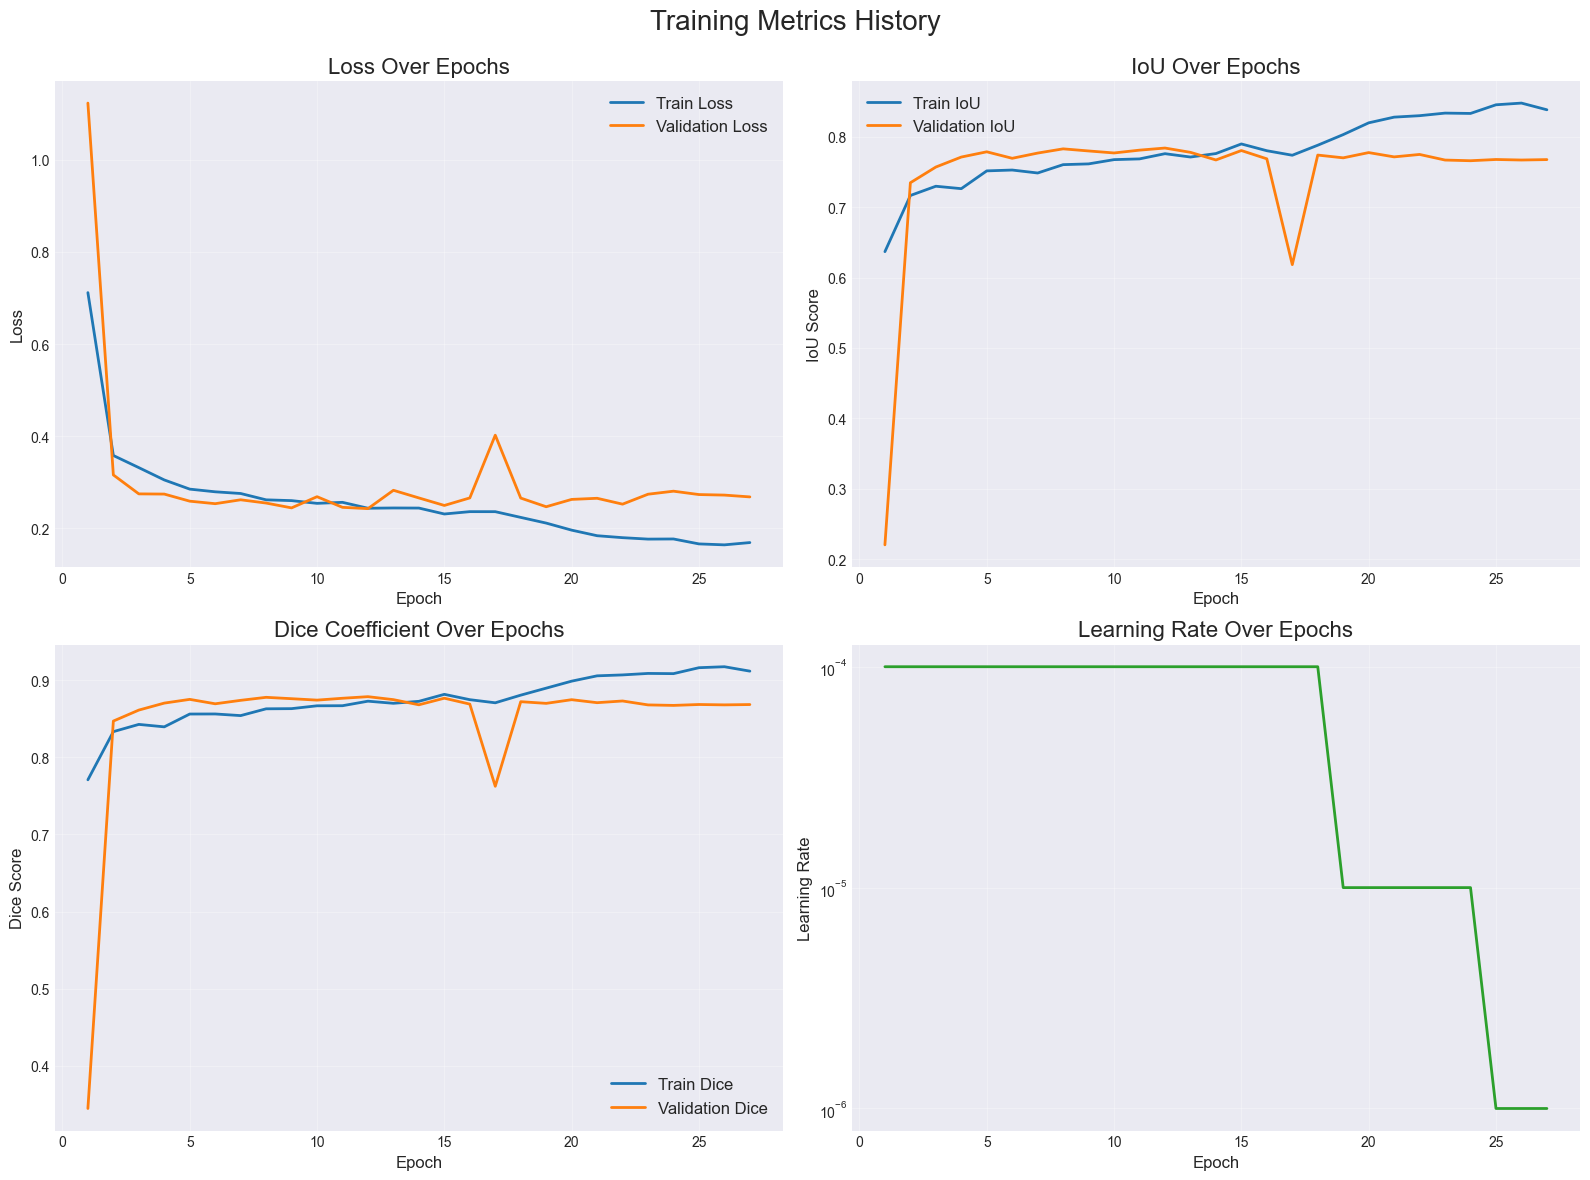

In [12]:
# Plot training history
plot_training_history(history)

In [13]:
# Load best model for evaluation
model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_model.pth'))

# Evaluate on test set
test_results = evaluate_model(model, test_loader, criterion)

Testing: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

Test Loss: 0.2241
Test IoU: 0.7859
Test Dice/F1: 0.8791
Test Accuracy: 0.8806
Test Precision: 0.8879
Test Recall: 0.8716


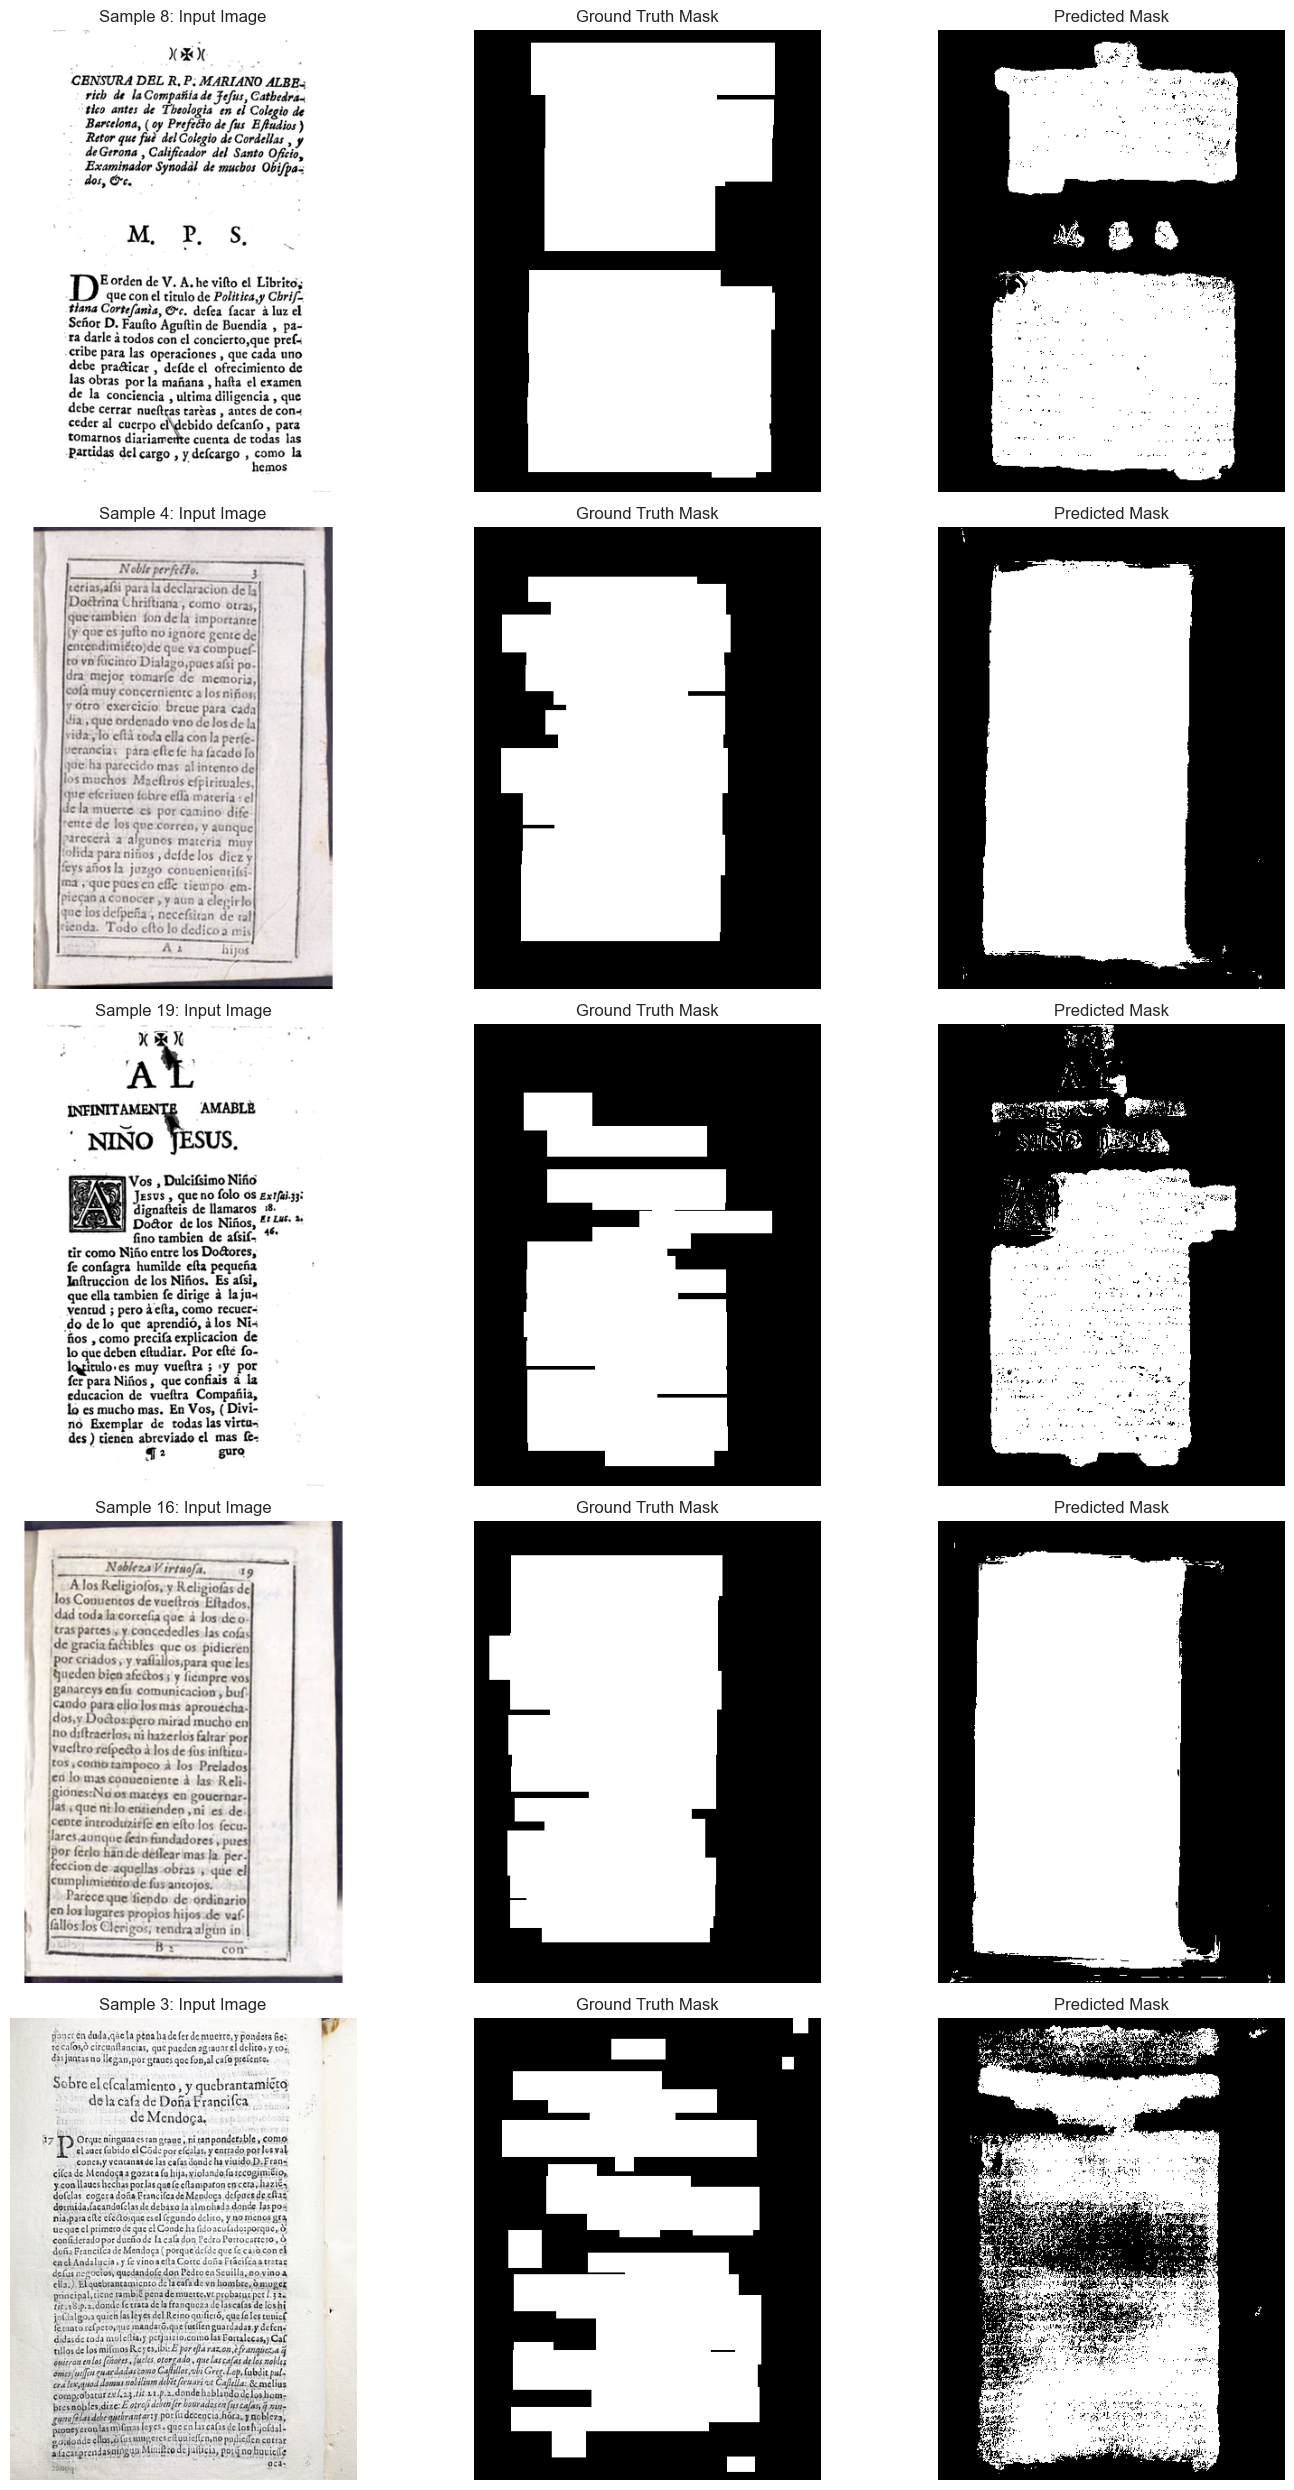

In [14]:
# Visualize predictions
visualize_predictions(test_results)
